In [1]:
import numpy as np
import math
import librosa
import glob

import IPython.display as ipd

import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

import torch
from torch import nn
import matplotlib.pyplot as plt


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from scipy.special import expit, logit


plt.style.use("dark_background")

pd.set_option("display.max_columns", 2500)
pd.set_option("display.max_rows", 50)

plt.style.use("dark_background")

%load_ext lab_black

# NN to classify pianists based on audio sample

### functions

In [2]:
### Data Preprocessing function with librosa
N_BINS = 60
HOP_LENGTH = 512


def get_logC(audio_file):
    y, sr = librosa.load(audio_file)
    C = librosa.cqt(
        y, sr=sr, fmin=librosa.note_to_hz("C1"), n_bins=N_BINS, hop_length=HOP_LENGTH
    )
    logC = librosa.amplitude_to_db(np.abs(C))
    df = pd.DataFrame(logC)
    return df


### Accuracy function
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = correct / len(y_true) * 100

    return acc


### Batch function


def split_batches(x, batch_size):
    return torch.split(x, batch_size)


### dict function
def get_keys_from_value(d, val):
    return [k for k, v in d.items() if v == val]


### set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### get audio files
audio_files = glob.glob("audio_files/**/*.mp3", recursive=True)

### Assign labels

In [3]:
### Assign classes

artist_dict = {
    "Gould": 0,
    "Ishizaka": 1,
    "Richter": 2,
    "Schiff": 3,
    "Tureck": 4,
    "Tharaud": 5,
    "Moravec": 6,
    "Rubinstein": 7,
    "Pogorelich": 8,
    "Nikolayeva": 9,
    "Horowitz": 10,
    "Crochet": 11,
}

for n in audio_files[0:]:
    artist = n.split("/")[1].split()[0]
    if artist not in artist_dict.keys():
        print(artist)

### Get data

In [4]:
### Get data

SECONDS_PER_SAMPLE = 10
chunk_size = SECONDS_PER_SAMPLE * 45  # 45 samples per second
X_list = []  # List to store X arrays
y_list = []  # List to store y arrays

for file in audio_files[0:]:
    t = get_logC(file)

    artist_mapping = file.split("/")[1].split()[0]

    array_list = []

    for n in range(len(t.columns) // chunk_size):
        arr = t[range(n * chunk_size, (n + 1) * chunk_size, 1)].T.to_numpy()
        array_list.append(arr)

    arrays = np.array(array_list)
    X_list.append(torch.tensor(arrays))
    y_list.append(torch.full((arrays.shape[0],), artist_dict[artist_mapping]))

X = torch.cat(X_list, dim=0)
y = torch.cat(y_list, dim=0)
y = y.to(torch.float32)

In [5]:
X[0]

tensor([[-66.4303, -66.4303, -66.4303,  ..., -66.4303, -66.4303, -66.4303],
        [-66.4303, -66.4303, -66.4303,  ..., -66.4303, -66.4303, -66.4303],
        [-66.4303, -66.4303, -66.4303,  ..., -66.4303, -66.4303, -66.4303],
        ...,
        [-52.3281, -37.7835, -38.3474,  ...,  -8.6718, -12.2944, -29.1438],
        [-49.0559, -37.7148, -38.4880,  ..., -10.4216, -13.2347, -25.9301],
        [-45.2367, -38.0367, -38.8387,  ...,  -5.6747, -11.9044, -28.6041]])

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [7]:
X.shape, y.shape

(torch.Size([7410, 450, 60]), torch.Size([7410]))

In [8]:
INITIAL_FEATURES = N_BINS  ## Set with librosa, 60 note classes

end_features = len(artist_dict)

### Model class

In [9]:
# 1. Model that subclasses nn.Module
class Model_1(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. create 2 nn.Linear capable of handling shape of  data
        self.layer_1 = nn.Linear(in_features=INITIAL_FEATURES, out_features=128)
        self.layer_2 = nn.Linear(in_features=128, out_features=256)
        self.layer_3 = nn.Linear(in_features=256, out_features=end_features)
        self.relu = nn.ReLU()
        self.batchnorm1 = nn.BatchNorm1d(INITIAL_FEATURES)
        self.batchnorm2 = nn.BatchNorm1d(128)
        self.batchnorm3 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(0.25)

    # 3. define the forward method that outlines the forward pass of the network
    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size

        x = x.view(-1, x.size(-1))  # Reshape

        x = self.relu(
            self.dropout(
                self.layer_3(
                    self.batchnorm3(
                        self.dropout(
                            self.relu(
                                self.layer_2(
                                    self.batchnorm2(
                                        self.dropout(
                                            self.relu(self.layer_1(self.batchnorm1(x)))
                                        )
                                    )
                                )
                            )
                        )
                    )
                )
            )
        )

        # x = self.dropout(
        #   self.relu(
        #      self.layer_2(
        #         self.batchnorm2(
        #            self.dropout(self.relu(self.layer_1(self.batchnorm1(x))))
        #       )
        #  )
        # )
        # )

        x = x.view(batch_size, chunk_size, end_features)  # Reshape

        return x


# 4. Instantiate the model and move it to the device

model_1 = Model_1().to(device)

# model_1 = torch.compile(model_1)

# loss
loss_fn = nn.CrossEntropyLoss()


# optimizer

# optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

### Training loop

In [13]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
EPOCHS = 1

# put data on device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# batch size
BATCH_SIZE = 8

num_batches = len(X_train) // BATCH_SIZE

X_train_batches = split_batches(X_train, BATCH_SIZE)

y_train_batches = split_batches(y_train, BATCH_SIZE)

# X_test_batches = split_batches(X_test, batch_size)

# y_test_batches = split_batches(y_test, batch_size)


# Build training and evaluation loops
for epoch in range(EPOCHS):
    for batch in range(num_batches):
        X_train_batch = X_train_batches[batch]

        y_train_batch = y_train_batches[batch]

        # X_test_batch = X_test_batches[batch]

        # y_test_batch = y_test_batches[batch]

        model_1.train()

        # forward pass

        y_logits = model_1(X_train_batch)

        print(f"y_logits.shape = {y_logits.shape}")

        y_preds = torch.mode(torch.argmax(torch.softmax(y_logits, dim=2), dim=2)).values

        print(f"y_preds = {y_preds}")

        # calculate loss and accuracy

        y_train_batch = y_train_batch.to(torch.long)

        losses = [loss_fn(y_logits[:, i, :], y_train_batch) for i in range(45)]

        

        loss = torch.stack(losses).mean()

    

        

        acc = accuracy_fn(y_true=y_train_batch, y_pred=y_preds)

        # optimizer zero grad
        optimizer.zero_grad()

        # backward pass (backpropagation)
        loss.backward()

        # step optimizer (gradient descent)
        optimizer.step()

    # testing
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test)  #

        # test_logits = test_logits.reshape(test_logits.size(0), -1)

        test_preds = torch.mode(
            torch.argmax(torch.softmax(test_logits, dim=2), dim=2)
        ).values

        y_test = y_test.to(torch.long)

        test_losses = [loss_fn(test_logits[:, i, :], y_test) for i in range(45)]
        test_loss = torch.stack(test_losses).mean()  # CrossEntropyLoss() expects logits

        test_acc = accuracy_fn(y_true=y_test, y_pred=test_preds)

    # print results
    if (epoch) % 10 == 0:
        print(
            f"Epoch: {epoch} | Train Loss: {loss:.5f} | Train Acc: {acc:.3f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.3f}%"
        )
        # print(
        #    pd.Series(
        #        (torch.mode(y_preds).values.cpu().detach().numpy())
        #    ).value_counts()
        # )

y_logits.shape = torch.Size([8, 450, 12])
y_preds = tensor([ 6,  9,  1,  8,  1,  5,  5, 11], device='cuda:0')
[tensor(2.3605, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.4619, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5993, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5459, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5404, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5702, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.4934, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5191, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.7201, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.6171, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.6487, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.6826, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.2832, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.5483, device='cuda:0', grad_fn=<NllLossBackward0>), tensor(2.6246, device='cuda:0', gra

NameError: name 'acc' is not defined

Text(0.5, 1.0, 'Confusion Matrix')

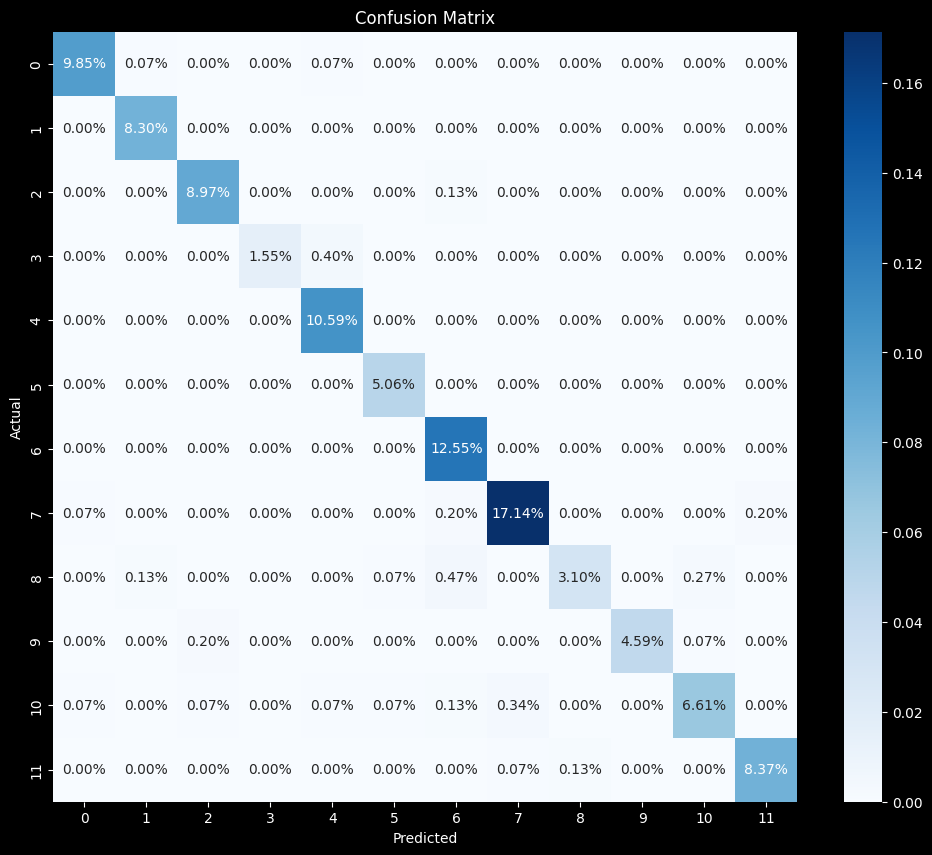

In [20]:
cf_matrix = confusion_matrix(
    y_test.cpu().detach().numpy(), test_preds.cpu().detach().numpy()
)

plt.figure(figsize=(12, 10))

sns.heatmap(
    cf_matrix / np.sum(cf_matrix),
    annot=True,
    fmt=".2%",
    cmap="Blues",
)


plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

In [21]:
results_df = pd.DataFrame(columns=["Predicted", "Actual"])

results_df["Predicted"], results_df["Actual"] = (
    pd.Series(test_preds.cpu().detach().numpy()).value_counts(),
    pd.Series(y_test.cpu().detach().numpy()).value_counts(),
)


results_df["accuracy"] = round(results_df["Predicted"] / results_df["Actual"], 3)

results_df

,Predicted,Actual,accuracy
7,260,261,0.996
6,200,186,1.075
4,165,157,1.051
0,148,148,1.000
2,137,135,1.015
11,127,127,1.000
1,126,123,1.024
10,103,109,0.945
5,77,75,1.027
9,68,72,0.944


# Memory management

In [41]:
del (
    model_1,
    loss_fn,
    optimizer,
    X_train,
    X_test,
    y_train,
    y_test,
    X_train_batches,
    y_train_batches,
    y_logits,
    y_preds,
    test_logits,
    test_preds,
    losses,
    test_losses,
    loss,
    test_loss,
    acc,
    test_acc,
    # batch_size,
    num_batches,
    batch,
)

torch.cuda.empty_cache()

In [32]:
import gc

gc.collect()

140

# Saving and loading models

In [97]:
len(model_1.state_dict())

11

In [98]:
torch.save(model_1.state_dict(), "model_1.pt")

In [21]:
model_1 = Model_1()

model_1.load_state_dict(torch.load("model_1.pt"))

model_1 = model_1.to(device)

# Evaluate model on unseen data

In [4]:
chunk_size = SECONDS_PER_SAMPLE * 45  # 45 samples per second
X_list = []  # List to store X arrays
y_list = []  # List to store y arrays


file = "test_audio/Rubinstein - Chopin Nocturne Op. 48 in C Minor.mp3"
# file = "test_audio/Nikolayeva - Shostakovich  P and F B2.mp3"
# file = "test_audio/Gould - Goldberg Variations, Aria.mp3"
# file = "test_audio/Moravec - Bach Chromatic Fantasia BVW 903.mp3"
# file = "test_audio/Crochet - Goldberg Variation.mp3"
# file = "test_audio/Pogorelich - Chopin 4 scherzi.mp3"

t = get_logC(file)

artist_mapping = file.split("/")[1].split()[0]

array_list = []

for n in range(len(t.columns) // chunk_size):
    arr = t[range(n * chunk_size, (n + 1) * chunk_size, 1)].T.to_numpy()
    array_list.append(arr)

arrays = np.array(array_list)
X_list.append(torch.tensor(arrays))
y_list.append(torch.full((arrays.shape[0],), artist_dict[artist_mapping]))


x_test_1 = torch.cat(X_list, dim=0)
y_test_1 = torch.cat(y_list, dim=0)
x_test_1 = x_test_1.to(device)


with torch.inference_mode():
    test_1_logits = model_1(x_test_1)

    test_1_pred = torch.mode(
        torch.argmax(torch.softmax(test_1_logits, dim=2), dim=2)
    ).values


# guesses.value_counts().plot(kind="bar")

print(
    f"Guess is: {get_keys_from_value(artist_dict, pd.Series(test_1_pred.cpu()).value_counts().index[0] )[0]}({pd.Series(test_1_pred.cpu()).value_counts().index[0]}), True is: {get_keys_from_value(artist_dict, pd.Series(y_test_1)[0])[0]}({pd.Series(y_test_1)[0]})"
)

pd.Series(test_1_pred.cpu()).value_counts()

NameError: name 'SECONDS_PER_SAMPLE' is not defined

In [45]:
artist_dict

{'Gould': 0,
 'Ishizaka': 1,
 'Richter': 2,
 'Schiff': 3,
 'Tureck': 4,
 'Tharaud': 5,
 'Moravec': 6,
 'Rubinstein': 7,
 'Pogorelich': 8,
 'Nikolayeva': 9,
 'Horowitz': 10,
 'Crochet': 11}